In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import wget
import missingno as msno
import pickle

## 1 - Read Population Data

In [84]:
url = 'https://www.ers.usda.gov/webdocs/DataFiles/48747/PopulationEstimates.xls'
population_file = wget.download(url)

Read the population data into a dataframe.

In [85]:
pop_df = pd.read_excel(population_file)
pop_df.head(3)

Population estimates for the U.S., States, and counties, 2010-19 (see the second tab in this workbook for variable name descriptions)  \
0  These data were posted to the ERS website (at ...                                                                                      
1                                            FIPStxt                                                                                      
2                                              00000                                                                                      

  Unnamed: 1     Unnamed: 2                       Unnamed: 3  \
0        NaN            NaN                              NaN   
1      State      Area_Name  Rural-urban_Continuum Code_2003   
2         US  United States                              NaN   

                        Unnamed: 4                 Unnamed: 5  \
0                              NaN                        NaN   
1  Rural-urban_Continuum Code_2013  Urban_Influence_Code_2003   
2                              NaN                        NaN   

                  Unnamed: 6              Unnamed: 7       Unnamed: 8  \
0                        NaN                     NaN              NaN   
1  Urban_Influence_Code_2013  Economic_typology_2015  CENSUS_2010_POP   
2                        NaN                     NaN        308745538   

            Unnamed: 9  ...         Unnamed: 155    Unnamed: 156  \
0                  NaN  ...                  NaN             NaN   
1  ESTIMATES_BASE_2010  ...  R_DOMESTIC_MIG_2019  R_NET_MIG_2011   
2            308758105  ...                  NaN             NaN   

     Unnamed: 157    Unnamed: 158    Unnamed: 159    Unnamed: 160  \
0             NaN             NaN             NaN             NaN   
1  R_NET_MIG_2012  R_NET_MIG_2013  R_NET_MIG_2014  R_NET_MIG_2015   
2             NaN             NaN             NaN             NaN   

     Unnamed: 161    Unnamed: 162    Unnamed: 163    Unnamed: 164  
0             NaN             NaN             NaN             NaN  
1  R_NET_MIG_2016  R_NET_MIG_2017  R_NET_MIG_2018  R_NET_MIG_2019  
2             NaN             NaN             NaN             NaN  

[3 rows x 165 columns]

### 1.1 - Cleanup Columns

Reread the excel file skipping the first two lines and only reading the columns of interest.

In [86]:
columns_of_interest = ['FIPStxt','State','Area_Name','POP_ESTIMATE_2019']
pop_df = pd.read_excel("PopulationEstimates.xls", usecols=columns_of_interest, skiprows=2)
pop_df.head()

FIPStxt State       Area_Name  POP_ESTIMATE_2019
0        0    US   United States          328239523
1     1000    AL         Alabama            4903185
2     1001    AL  Autauga County              55869
3     1003    AL  Baldwin County             223234
4     1005    AL  Barbour County              24686

In [87]:
pop_df.shape

(3273, 4)

In [88]:
# Rename the Area_Name and POP_ESTIMATE_2019 columns to County and Population.
pop_df.rename(columns = {'FIPStxt':'FIPS','Area_Name':'County', 'POP_ESTIMATE_2019':'Population'}, inplace = True)
pop_df.columns

Index(['FIPS', 'State', 'County', 'Population'], dtype='object')

### 1.2 - Remove Irrelevant Data

In [89]:
# Look for any "bad" States
print(pop_df["State"].value_counts())

TX    255
GA    160
VA    134
KY    121
MO    116
KS    106
IL    103
NC    101
IA    100
TN     96
NE     94
IN     93
OH     89
MN     88
MI     84
MS     83
PR     79
OK     78
AR     76
WI     73
PA     68
AL     68
FL     68
SD     67
CO     65
LA     65
NY     63
CA     59
MT     57
WV     56
ND     54
SC     47
ID     45
WA     40
OR     37
NM     34
UT     30
AK     30
MD     25
WY     24
NJ     22
NV     18
ME     17
AZ     16
MA     15
VT     15
NH     11
CT      9
HI      6
RI      6
DE      4
DC      2
US      1
Name: State, dtype: int64


Only the US record is extraneous. Remove this record since it doesn't represent a state.

In [90]:
pop_df = pop_df[pop_df.State != "US"]
pop_df.shape

(3272, 4)

Now look for State names inthe County column.

In [91]:
states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','District of Columbia','Delaware',
          'Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine',
          'Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada',
          'New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma',
          'Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont',
          'Virginia','Washington','West Virginia','Wisconsin','Wyoming']
len(states)

51

In [92]:
pop_df[pop_df['County'].isin(states)]

FIPS State                County  Population
1      1000    AL               Alabama     4903185
69     2000    AK                Alaska      731545
99     4000    AZ               Arizona     7278717
115    5000    AR              Arkansas     3017804
191    6000    CA            California    39512223
250    8000    CO              Colorado     5758736
315    9000    CT           Connecticut     3565287
324   10000    DE              Delaware      973764
328   11000    DC  District of Columbia      705749
329   11001    DC  District of Columbia      705749
330   12000    FL               Florida    21477737
398   13000    GA               Georgia    10617423
558   15000    HI                Hawaii     1415872
564   16000    ID                 Idaho     1787065
609   17000    IL              Illinois    12671821
712   18000    IN               Indiana     6732219
805   19000    IA                  Iowa     3155070
905   20000    KS                Kansas     2913314
1011  21000    KY              Kentucky     4467673
1132  22000    LA             Louisiana     4648794
1197  23000    ME                 Maine     1344212
1214  24000    MD              Maryland     6045680
1239  25000    MA         Massachusetts     6892503
1254  26000    MI              Michigan     9986857
1338  27000    MN             Minnesota     5639632
1426  28000    MS           Mississippi     2976149
1509  29000    MO              Missouri     6137428
1625  30000    MT               Montana     1068778
1682  31000    NE              Nebraska     1934408
1776  32000    NV                Nevada     3080156
1794  33000    NH         New Hampshire     1359711
1805  34000    NJ            New Jersey     8882190
1827  35000    NM            New Mexico     2096829
1861  36000    NY              New York    19453561
1924  37000    NC        North Carolina    10488084
2025  38000    ND          North Dakota      762062
2079  39000    OH                  Ohio    11689100
2168  40000    OK              Oklahoma     3956971
2246  41000    OR                Oregon     4217737
2283  42000    PA          Pennsylvania    12801989
2351  44000    RI          Rhode Island     1059361
2357  45000    SC        South Carolina     5148714
2404  46000    SD          South Dakota      884659
2471  47000    TN             Tennessee     6829174
2567  48000    TX                 Texas    28995881
2822  49000    UT                  Utah     3205958
2852  50000    VT               Vermont      623989
2867  51000    VA              Virginia     8535519
3001  53000    WA            Washington     7614893
3041  54000    WV         West Virginia     1792147
3097  55000    WI             Wisconsin     5822434
3170  56000    WY               Wyoming      578759

Drop the rows with State level data.

In [93]:
pop_df = pop_df[~pop_df['County'].isin(states)].reset_index(drop=True)
pop_df.shape

(3220, 4)

Drop any duplicate rows.

In [94]:
# Find any rows that are duplicates.
[row for row in pop_df.duplicated(keep='last') if row == True]

[]

In [95]:
# No duplicates were found, so dropping duplicates will not have any effect.
pop_df = pop_df.drop_duplicates(keep='last')
pop_df.shape

(3220, 4)

### 1.3 - Cleanup Missing Data

Visualize the population dataframe to identify any missing data

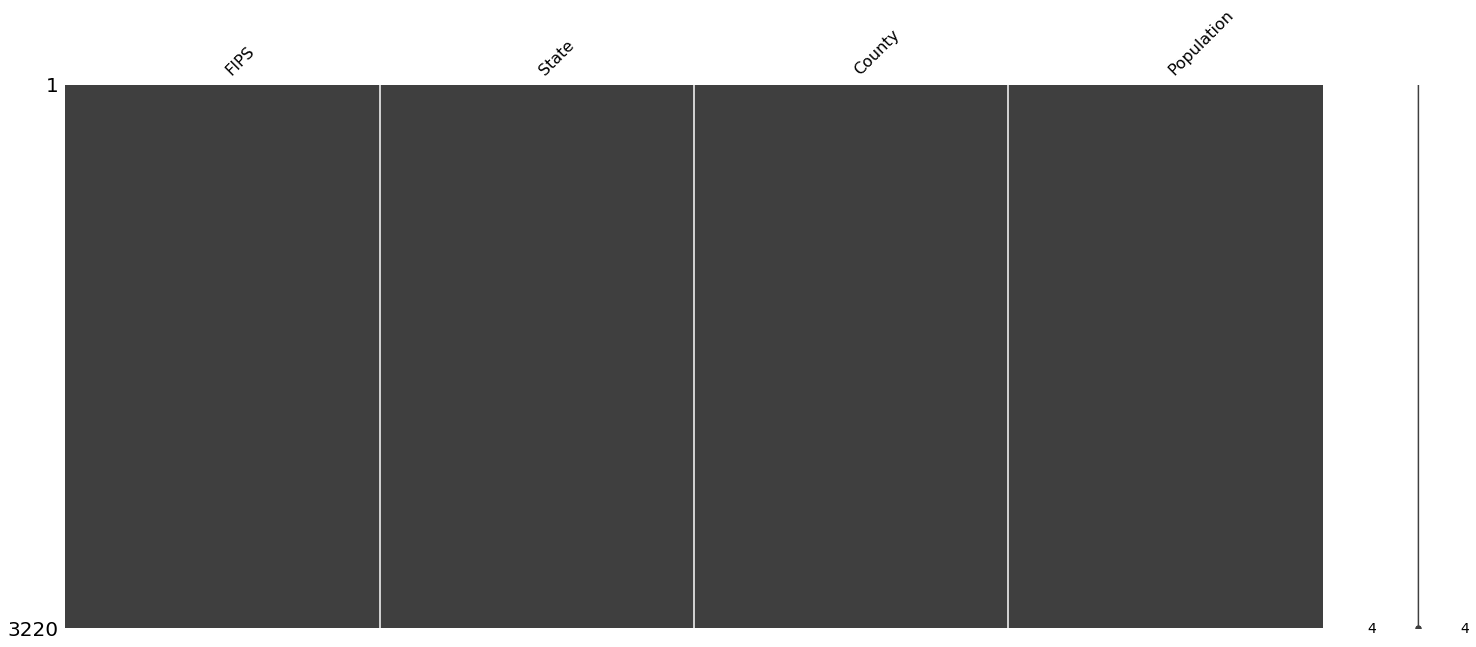

In [96]:
msno.matrix(pop_df)

No missing data

### 1.4 - Verify Data Types

In [97]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220 entries, 0 to 3219
Data columns (total 4 columns):
FIPS          3220 non-null int64
State         3220 non-null object
County        3220 non-null object
Population    3220 non-null int64
dtypes: int64(2), object(2)
memory usage: 125.8+ KB


In [98]:
pop_df.State.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR'], dtype=object)

The expected 50 states plus Puerto Rico and Washington, DC are included in the study.

## 2 - Read Land Area Data

In [99]:
url = 'https://www2.census.gov/library/publications/2011/compendia/usa-counties/excel/LND01.xls'
land_area_file = wget.download(url)

Read the land area data into a dataframe.

In [100]:
land_area_df = pd.read_excel(land_area_file)
land_area_df.head(3)

Areaname  STCOU  LND010190F  LND010190D  LND010190N1  LND010190N2  \
0  UNITED STATES      0           0  3787425.08            0            0   
1        ALABAMA   1000           0    52422.94            0            0   
2    Autauga, AL   1001           0      604.49            0            0   

   LND010200F  LND010200D  LND010200N1  LND010200N2  ...  LND110210N1  \
0           0  3794083.06            0            0  ...            0   
1           0    52419.02            0            0  ...            0   
2           0      604.45            0            0  ...            0   

   LND110210N2  LND210190F  LND210190D  LND210190N1  LND210190N2  LND210200F  \
0            0           0   251083.35            0            0           0   
1            0           0     1672.71            0            0           0   
2            0           0        8.48            0            0           0   

   LND210200D  LND210200N1  LND210200N2  
0   256644.62            0            0  
1     1675.01            0            0  
2        8.48            0            0  

[3 rows x 34 columns]

### 2.1 - Cleanup Columns

Reread the excel file and only keep the following columns of interest:
- STCOU - FIPS code for state or county
- Areaname - County and State
- LND110210D - Land area in square miles, 2010 SQM

In [101]:
columns_of_interest = ['Areaname','STCOU','LND110210D']
land_area_df = pd.read_excel("LND01.xls", usecols=columns_of_interest, skiprows=0)
land_area_df.head()

Areaname  STCOU  LND110210D
0  UNITED STATES      0  3531905.43
1        ALABAMA   1000    50645.33
2    Autauga, AL   1001      594.44
3    Baldwin, AL   1003     1589.78
4    Barbour, AL   1005      884.88

In [102]:
land_area_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 3 columns):
Areaname      3198 non-null object
STCOU         3198 non-null int64
LND110210D    3198 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 75.0+ KB


## 3 - Merge Population and Land Area Data

### 3-1 - Cleanup FIPS Codes

Compare FIPS codes before joining the dataframes to determine any anamolies.

In [103]:
# Unique FIPS codes in the population data.
len(pop_df.FIPS.unique())

3220

In [104]:
# Unique FIPS codes in the land area data for counties.
len(land_area_df.STCOU.unique())

3198

Inspect the different codes to determine if rows can be removed.

In [105]:
# FIPS codes in the Population data but not in the Land Area data.
no_land_area_df = pop_df[~pop_df.FIPS.isin(land_area_df.STCOU.values)]
no_land_area_df.shape

(81, 4)

In [106]:
no_land_area_df.sample(5)

FIPS State                            County  Population
3169  72054    PR    Florida Municipio, Puerto Rico       11317
3144  72005    PR  Aguadilla Municipio, Puerto Rico       50265
3170  72055    PR    Guánica Municipio, Puerto Rico       15383
3153  72023    PR  Cabo Rojo Municipio, Puerto Rico       47515
3149  72015    PR     Arroyo Municipio, Puerto Rico       17238

In [107]:
print(no_land_area_df["State"].value_counts())

PR    79
AK     1
SD     1
Name: State, dtype: int64


In [108]:
# FIPS codes in the land area data but not in the Population data.
no_pop_df = land_area_df[~land_area_df.STCOU.isin(pop_df.FIPS.values)]
no_pop_df.shape

(59, 3)

In [109]:
no_pop_df

Areaname  STCOU  LND110210D
0                     UNITED STATES      0  3531905.43
1                           ALABAMA   1000    50645.33
69                           ALASKA   2000   570640.95
95                 Wade Hampton, AK   2270    17081.43
99                          ARIZONA   4000   113594.08
115                        ARKANSAS   5000    52035.48
191                      CALIFORNIA   6000   155779.22
250                        COLORADO   8000   103641.89
315                     CONNECTICUT   9000     4842.36
324                        DELAWARE  10000     1948.54
328            DISTRICT OF COLUMBIA  11000       61.05
329            District of Columbia  11001       61.05
330                         FLORIDA  12000    53624.76
398                         GEORGIA  13000    57513.49
558                          HAWAII  15000     6422.63
564                           IDAHO  16000    82643.12
609                        ILLINOIS  17000    55518.93
712                         INDIANA  18000    35826.11
805                            IOWA  19000    55857.13
905                          KANSAS  20000    81758.72
1011                       KENTUCKY  21000    39486.34
1132                      LOUISIANA  22000    43203.90
1197                          MAINE  23000    30842.92
1214                       MARYLAND  24000     9707.24
1239                  MASSACHUSETTS  25000     7800.06
1254                       MICHIGAN  26000    56538.90
1338                      MINNESOTA  27000    79626.74
1426                    MISSISSIPPI  28000    46923.27
1509                       MISSOURI  29000    68741.52
1625                        MONTANA  30000   145545.80
1682  Yellowstone National Park, MT  30113        0.00
1683                       NEBRASKA  31000    76824.17
1777                         NEVADA  32000   109781.18
1795                  NEW HAMPSHIRE  33000     8952.65
1806                     NEW JERSEY  34000     7354.22
1828                     NEW MEXICO  35000   121298.15
1862                       NEW YORK  36000    47126.40
1925                 NORTH CAROLINA  37000    48617.91
2026                   NORTH DAKOTA  38000    69000.80
2080                           OHIO  39000    40860.69
2169                       OKLAHOMA  40000    68594.92
2247                         OREGON  41000    95988.01
2284                   PENNSYLVANIA  42000    44742.70
2352                   RHODE ISLAND  44000     1033.81
2358                 SOUTH CAROLINA  45000    30060.70
2405                   SOUTH DAKOTA  46000    75811.00
2461                    Shannon, SD  46113     2093.90
2472                      TENNESSEE  47000    41234.90
2568                          TEXAS  48000   261231.71
2823                           UTAH  49000    82169.62
2853                        VERMONT  50000     9216.66
2868                       VIRGINIA  51000    39490.09
2965                    Bedford, VA  51515        6.88
2970              Clifton Forge, VA  51560        0.00
2998               South Boston, VA  51780        0.00
3005                     WASHINGTON  53000    66455.52
3045                  WEST VIRGINIA  54000    24038.21
3101                      WISCONSIN  55000    54157.80
3174                        WYOMING  56000    97093.14

These records represent non-county or incomplete population or land area level data and can be dropped.

### 3.2 - Merge Dataframes

Perform inner join to combine the two dataframes eliminating both extraneous sets of data above.

In [110]:
df = pop_df.merge(land_area_df, how="inner", left_on='FIPS', right_on='STCOU').drop(['STCOU', 'Areaname'], axis=1)
df.shape

(3139, 5)

Rename Columns

In [111]:
df.rename(columns = {'LND110210D':'Land_Area'}, inplace = True)

In [112]:
df.sample(5)

FIPS State             County  Population  Land_Area
1381  27139    MN       Scott County      149013     356.48
107    4023    AZ  Santa Cruz County       46498    1236.92
2668  48297    TX    Live Oak County       12207    1039.70
1964  37153    NC    Richmond County       44829     473.82
783   18177    IN       Wayne County       65884     401.74

In [113]:
df.shape

(3139, 5)

### 3.3 - Cleanup Missing Data

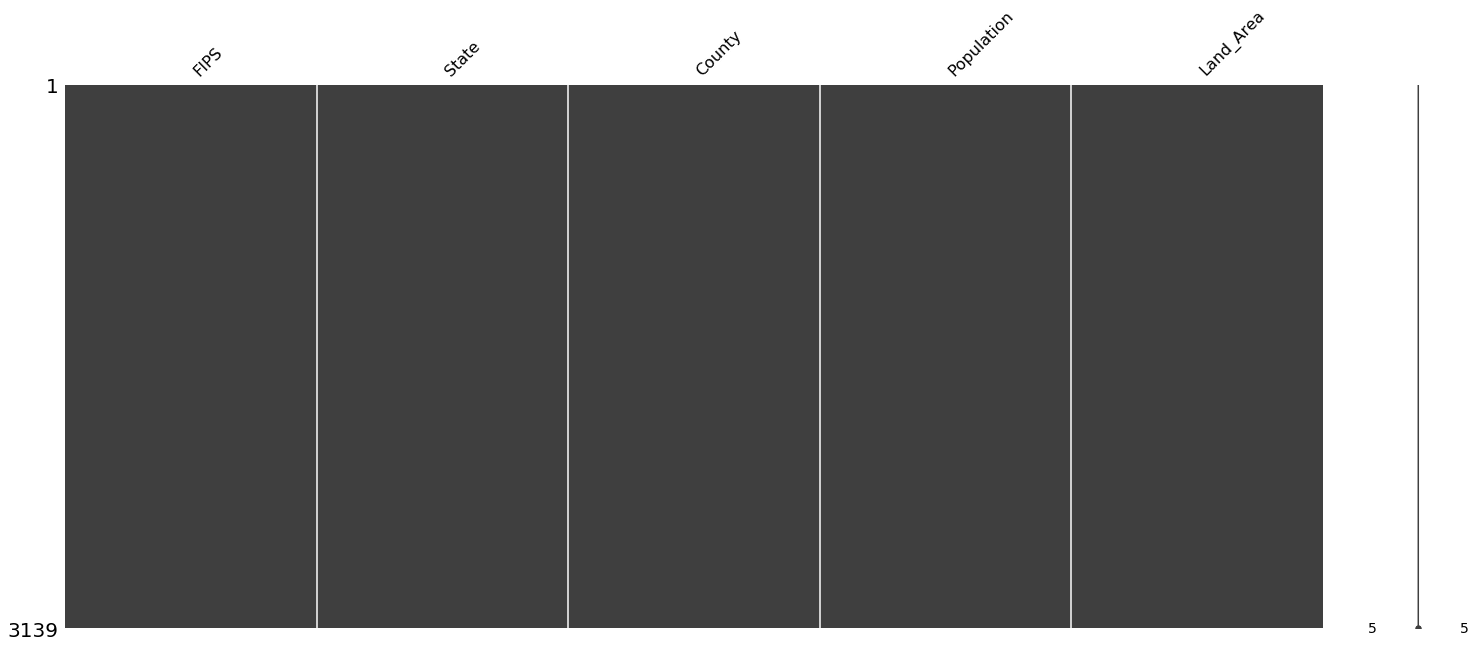

In [114]:
msno.matrix(df)

No missing data.

### 3.4 - Function: ratio

Used to calculate ratios for the study such as "Population per square mile"


In [115]:
def ratio(x, y):

    # Return ratio as an integer.
    return int(x / y)

Test the ratio function

In [116]:
# pop_square_mile test (example - more population than square mileage)
ratio(10039107, 4057.88)

2473

In [117]:
# pop_square_mile test (example - more square mileage than population)
ratio(169, 668.93) 

0

### 3.5 - Add Population Per Square Mile Column

Apply the ratio function to add "Population per Square Mile" column to each record

In [118]:
df["Pop_Sq_Mile"] = df[["Population", "Land_Area"]].apply(lambda x: ratio(*x), axis=1)

In [119]:
df.sample(3)

FIPS State         County  Population  Land_Area  Pop_Sq_Mile
2524  48009    TX  Archer County        8553     903.11            9
1015  21049    KY   Clark County       36263     252.46          143
2405  46093    SD   Meade County       28332    3470.98            8

Reorder columns

In [120]:
df = df[['FIPS','County','State','Land_Area','Population','Pop_Sq_Mile']]
df.sample(3)

FIPS            County State  Land_Area  Population  Pop_Sq_Mile
165    5111   Poinsett County    AR     758.39       23528           31
2023  38071     Ramsey County    ND    1186.85       11519            9
1848  36045  Jefferson County    NY    1268.59      109834           86

### 3.6 Characterize Cleaned Data

Show the mean, min, and max for each variable in the dataframe.

In [121]:
df.describe(include="all")

FIPS             County State      Land_Area    Population  \
count    3139.000000               3139  3139    3139.000000  3.139000e+03   
unique           NaN               1874    50            NaN           NaN   
top              NaN  Washington County    TX            NaN           NaN   
freq             NaN                 30   254            NaN           NaN   
mean    30393.808538                NaN   NaN    1119.039105  1.043362e+05   
std     15154.834504                NaN   NaN    3602.323872  3.334350e+05   
min      1001.000000                NaN   NaN       2.000000  8.600000e+01   
25%     18180.000000                NaN   NaN     430.915000  1.090400e+04   
50%     29177.000000                NaN   NaN     615.630000  2.575800e+04   
75%     45080.000000                NaN   NaN     923.665000  6.804750e+04   
max     56045.000000                NaN   NaN  145504.790000  1.003911e+07   

         Pop_Sq_Mile  
count    3139.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean      268.768398  
std      1775.239945  
min         0.000000  
25%        16.000000  
50%        44.000000  
75%       118.000000  
max     71340.000000

### 4 - Plot Data

Display an interactive scatter plot of the population versus density by County.

In [122]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe_connected'

In [124]:
fig = px.scatter(df,x='Population', y='Pop_Sq_Mile',hover_data=['State','County'])
fig.update_layout(title="County Population versus Density", title_x=0.5)
fig.show()

### 5 - Save Population Density dataframe to Pickle File

In [125]:
df.to_pickle("./population.pkl")